# Exp36

### Train a model for each dataset category, comparing it to random data

In [99]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByFile
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

In [2]:
pwd

'/home/atila.alr/Sync/codebase/src/github.com/atilaromero/ML/carving-lab'

In [48]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp36'

In [6]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rndset = Dataset.new_from_folders(random_dataset_folder).filter_min_max(minimum, maximum)

# Create models

In [ ]:
gen_rndchk_models(raw_dataset_folder, random_dataset_folder, minimum, maximum, result_dir)

# Load models

In [8]:
cat_models = {}
for cat in list(rawset.categories):
    print(cat)
    model = tensorflow.keras.models.load_model('results/exp36/%s_random.h5'%cat)
    cat_models[cat] = model

java
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
jpg
kml
pdf
kmz
text
xml
png
rtf
ps
gif
f
wp
pptx
pps
swf
txt
ppt
unk
log
xls
csv
html
gz
eps
dbase3
dwf
doc
hlp
sql


# Evaluate models accuracy

In [17]:
by_category = rawset.by_category()
rep = report.Reporter2(os.path.join(result_dir, 'experiments.tsv'))
for cat, model in cat_models.items():
    dset = rndset.join(by_category[cat])
    r = evaluate_rnd_model(cat, model, dset)
    rep.line(**r)
    print(r.values())
rep.close()


odict_values(['doc', 0.13294830024242402, 0.9595, 0.9595])
odict_values(['csv', 1.1943280782134024e-07, 1.0, 1.0])
odict_values(['png', 0.6314608812332153, 0.68925, 0.68925])
odict_values(['unk', 0.038713449612259865, 0.99, 0.99])
odict_values(['gif', 0.290908420085907, 0.8885, 0.8885])
odict_values(['ps', 0.004029641702771869, 0.99975, 0.99975])
odict_values(['kmz', 0.5346010267734528, 0.745, 0.745])
odict_values(['sql', 1.1920928955078125e-07, 1.0, 1.0])
odict_values(['pdf', 0.713506531715393, 0.66875, 0.66875])
odict_values(['gz', 0.5563446342945099, 0.718, 0.718])
odict_values(['log', 1.1920928955078125e-07, 1.0, 1.0])
odict_values(['kml', 1.1920928955078125e-07, 1.0, 1.0])
odict_values(['dwf', 1.2896759152412414, 0.6075, 0.6075])
odict_values(['swf', 0.6432314097881318, 0.69975, 0.69975])
odict_values(['dbase3', 1.1920928955078125e-07, 1.0, 1.0])
odict_values(['f', 0.01720931362139737, 0.99875, 0.99875])
odict_values(['txt', 8.96546884973759e-05, 1.0, 1.0])
odict_values(['html', 1

# Evaluate datasets randomness

In [56]:
def evaluate_dataset_randomness_full(name, model, dset):
    b_counter = 0
    g_counter = 0
    if len(dset.categories) != 1:
        print('multiple categories in dataset!')
    for filename in dset.filenames:
        with open(filename, 'rb') as infile:
            while(True):
                b = infile.read(51200)
                if len(b) == 0:
                    break
                bs = []
                for i in range(0, len(b), 512):
                    b2 = b[i:i+512]
                    blk = np.zeros((512,), dtype='int')
                    blk[:len(b2)] = [int(x) for x in b2]
                    bs.append(blk)
                ys = model.predict(xs_encoder_8bits_11(bs))
                for i, y in enumerate(ys):
                    if np.argmax(y, axis=-1) == 1:
                        b_counter+=1
                    else:
                        g_counter+=1
    return OrderedDict(
        name=name,
        g_counter=g_counter,
        b_counter=b_counter,
        randomness=b_counter/(g_counter+b_counter)
    )

In [75]:
def evaluate_dataset_randomness(category, model, dset):
    if len(dset.categories) != 1:
        print('multiple categories in dataset!')
    dset = dset.clone(categories=[category, 'zzz'])
    dsampler = block_sampler.BlockSampler(dset)
    dbenc = BatchEncoder(dsampler, 100, xs_encoder='8bits_11')
    result = model.evaluate_generator(iter(dbenc), steps=50)
    return OrderedDict(
        category=category,
        randomness=1-result[-1]
    )

In [76]:
eps_set = rawset.by_category()['eps']
eps_set.rebuild_categories(categories=['eps', 'zzz'])
evaluate_dataset_randomness('eps', cat_models['eps'], rawset.by_category()['eps'])

OrderedDict([('category', 'eps'), ('randomness', 0.011200010776519775)])

In [77]:
randomness = {}
for cat, model in cat_models.items():
    print(cat)
    randomness[cat] = evaluate_dataset_randomness(cat, model, rawset.by_category()[cat])

java
jpg
kml
pdf
kmz
text
xml
png
rtf
ps
gif
f
wp
pptx
pps
swf
txt
ppt
unk
log
xls
csv
html
gz
eps
dbase3
dwf
doc
hlp
sql


In [83]:
rep = report.Reporter2(os.path.join(result_dir, 'randomness.tsv'))
for r in randomness.values():
    rep.line(**r)
    print(r.values())
rep.close()

odict_values(['java', 0.0])
odict_values(['jpg', 0.062399983406066895])
odict_values(['kml', 0.0])
odict_values(['pdf', 0.06019997596740723])
odict_values(['kmz', 0.13899999856948853])
odict_values(['text', 0.07239997386932373])
odict_values(['xml', 0.001600027084350586])
odict_values(['png', 0.11260002851486206])
odict_values(['rtf', 0.006399989128112793])
odict_values(['ps', 0.019999980926513672])
odict_values(['gif', 0.0658000111579895])
odict_values(['f', 0.003600001335144043])
odict_values(['wp', 0.001999974250793457])
odict_values(['pptx', 0.16680002212524414])
odict_values(['pps', 0.11080002784729004])
odict_values(['swf', 0.15119999647140503])
odict_values(['txt', 0.0])
odict_values(['ppt', 0.14099997282028198])
odict_values(['unk', 0.020799994468688965])
odict_values(['log', 0.0])
odict_values(['xls', 0.013400018215179443])
odict_values(['csv', 0.000599980354309082])
odict_values(['html', 0.0])
odict_values(['gz', 0.1574000120162964])
odict_values(['eps', 0.0098000168800354])


# Plot

In [16]:
data = pd.read_csv('results/exp36/experiments.tsv', sep='\t')
data[:2]

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy
0,unk,19,3m48s,0.982375,0.982375
1,jpg,11,2m12s,0.531750,0.531750


In [30]:
data = data.sort_values('val_categorical_accuracy')

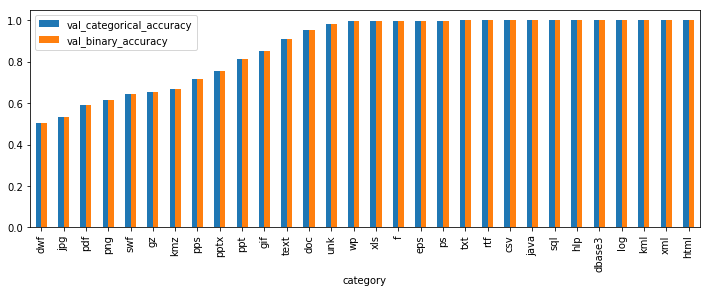

In [42]:
data.plot.bar('category', ['val_categorical_accuracy','val_binary_accuracy'], figsize=(12,4))
plt.show()

In [84]:
rdata = pd.read_csv('results/exp36/randomness.tsv', sep='\t')
rdata[:2]

,category,randomness
0,java,0.0000
1,jpg,0.0624


In [92]:
mdata = pd.merge(data, rdata)
mdata[:2]

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy,randomness
0,dwf,9,1m50s,0.506375,0.506375,0.0502
1,jpg,11,2m12s,0.531750,0.531750,0.0624


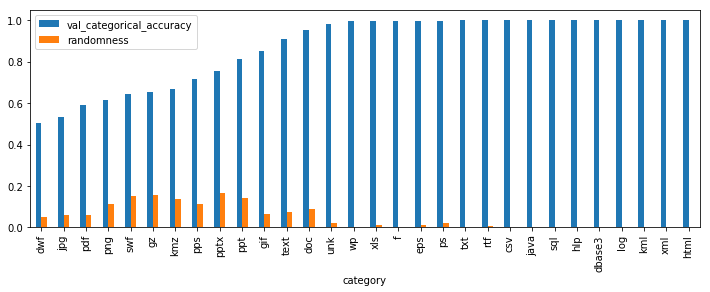

In [93]:
mdata.plot.bar('category', ['val_categorical_accuracy','randomness'], figsize=(12,4))
plt.show()

In [89]:
mdata = mdata.sort_values('randomness')

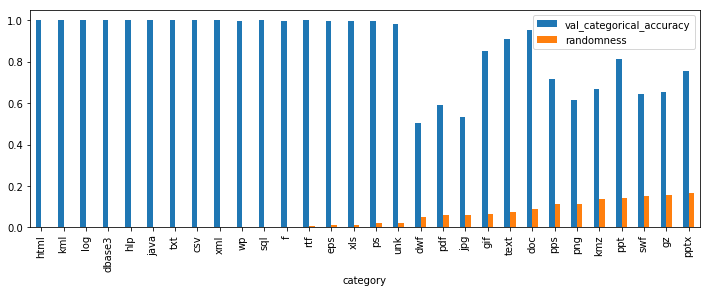

In [90]:
mdata.plot.bar('category', ['val_categorical_accuracy','randomness'], figsize=(12,4))
plt.show()

In [91]:
mdata['category']

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy,randomness
29,html,5,1m01s,1.000000,1.000000,0.0000
27,kml,5,1m04s,1.000000,1.000000,0.0000
26,log,5,1m00s,1.000000,1.000000,0.0000
25,dbase3,5,1m03s,1.000000,1.000000,0.0000
24,hlp,5,1m02s,1.000000,1.000000,0.0000
22,java,5,1m02s,1.000000,1.000000,0.0000
19,txt,6,1m13s,0.999375,0.999375,0.0000
21,csv,5,1m01s,0.999875,0.999875,0.0006
28,xml,5,1m01s,1.000000,1.000000,0.0016
14,wp,6,1m17s,0.996500,0.996500,0.0020


In [95]:
selected = mdata[mdata['val_categorical_accuracy']<0.96]
selected

,category,Epochs,Time,val_binary_accuracy,val_categorical_accuracy,randomness
0,dwf,9,1m50s,0.506375,0.506375,0.0502
1,jpg,11,2m12s,0.531750,0.531750,0.0624
2,pdf,9,1m49s,0.590875,0.590875,0.0602
3,png,10,2m03s,0.613125,0.613125,0.1126
4,swf,11,2m20s,0.644000,0.644000,0.1512
5,gz,11,2m14s,0.655500,0.655500,0.1574
6,kmz,12,2m22s,0.669375,0.669375,0.1390
7,pps,9,2m15s,0.715500,0.715500,0.1108
8,pptx,11,2m22s,0.754000,0.754000,0.1668
9,ppt,10,1m59s,0.813750,0.813750,0.1410


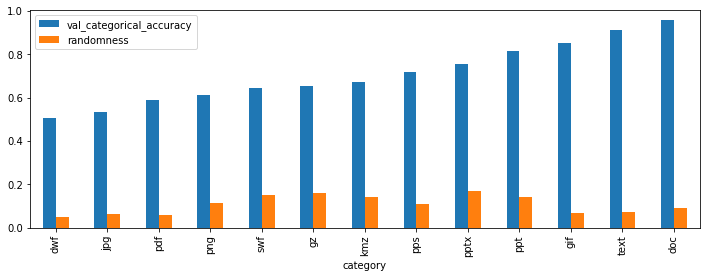

In [96]:
selected.plot.bar('category', ['val_categorical_accuracy','randomness'], figsize=(12,4))
plt.show()

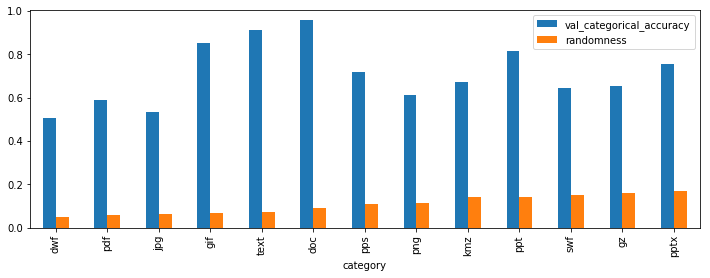

In [98]:
selected = selected.sort_values('randomness')
selected.plot.bar('category', ['val_categorical_accuracy','randomness'], figsize=(12,4))
plt.show()

In [120]:
selected.category

0      dwf
2      pdf
1      jpg
10     gif
11    text
12     doc
7      pps
3      png
6      kmz
9      ppt
4      swf
5       gz
8     pptx
Name: category, dtype: object

# Filter dataset

In [ ]:
def filter_dataset(model, dset):
    filtered = {}
    for filename in dset.filenames:
        sector_count = count_sectors(filename)
        filtered[filename] = np.zeros((sector_count,))
        with open(filename, 'rb') as infile:
            for sector in range(sector_count):
                b = infile.read(512)
                assert len(b) > 0
                blk = np.zeros((512,), dtype='int')
                blk[:len(b)] = [int(x) for x in b]
                ys = model.predict(xs_encoder_8bits_11([blk]))
                y = ys[0]
                filtered[filename][sector] = np.argmax(y, axis=-1)
    return filtered

In [117]:
def save_filtered(filtered, filepath):
    with open(filepath, 'wb') as f:
        for k, v in filtered.items():
            f.write(str.encode('%s\t' % k))
            for n in v:
                f.write(str.encode(str(int(n))))
            f.write(b'\n')

In [119]:
for cat in cat_models:
    print(cat)
    filtered = filter_dataset(cat_models[cat], rawset.by_category()[cat])
    save_filtered(filtered, result_dir + '/' + cat + '.rnd')

java
jpg
kml
pdf
kmz
text
xml
png
rtf
ps
gif
f
wp
pptx
pps
swf
txt
ppt
unk
log
xls
csv
html
gz
eps
dbase3
dwf
doc
hlp
sql
